### Using Real-world Images

**OBS.: NO COLAB, UTILIZE UMA MÁQUINA COM GPU PARA ESTE EXEMPLO**

Até agora vimos como construir uma Rede Neural Densa para classificação e melhorar a performance dela adicionando camadas de Convolução.

A limitação dos exemplos anteriores era que usávamos bases de dados com imagens bem uniformes, onde os objetos de interesse estavam bem centralizados e em um formato padrão de 28x28 pixels. Mas no mundo real, em geral nos depararamos com imagens de tamanhos maiores e com dimensões não uniformes, onde o objeto de interesse está localizado em diferentes regiões da imagem.

Outra questão é que anteriormente as bases de dados vinham junto com as bibliotecas, frameworks e APIs utilizados, já separada em grupos para treino e teste e já com os labels estabelecidos. Mas, novamente, é bem comum que essas condições não estejam disponíveis, e teremos que:
- Carregar a base de dados a partir de arquivos de imagens, atribuindo labels para os dados;
- Escolher como separar os dados em grupos para treino e teste;
- Ajustar para que os dados (as imagens) se adequem ao formato de entrada da rede; etc.

Assim, neste exemplo utilizaremos a base de dados [humanos ou cavalos](https://www.tensorflow.org/datasets/catalog/horses_or_humans?hl=pt-br), que pode ser baixada no [link](https://laurencemoroney.com/datasets.html), para explorar alternativas para as questões citadas anteriormente. Ela contém mais de 1000 imagens de humanos e cavalos em diferentes poses e com diversos tamanhos de arquivos.

Algumas das imagens da base de dados "humanos ou cavalos":

<img src="https://storage.googleapis.com/tfds-data/visualization/fig/horses_or_humans-3.0.0.png" width="500"></img>


Importando as bibliotecas necessárias

In [1]:
import os
import random
import numpy as np

# Para plotar e lidar com imagens:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

#### Brincando um pouco com as imagens

Considerando que a base de dados já está baixada e descompactada no computador ou drive (no caso do Google Colab).

A pasta base `horse-or-human` contém duas subpastas, `horses` e `humans`, onde as imagens estão localizadas. Com uma estrutura deste tipo não precisamos necessariamente colocar os labels das imagens como cavalos e humanos, já que a função que vamos usar para carregar as imagens vai colocar labels de acordo com a estrutura da pasta automaticamente.

##### Para o colab:

No colab, a maneira de acessar os arquivos do seu drive é diferente. Para tal, usamos a `google.colab.drive`. As pastas do drive podem ser acessadas através de `/content/drive/MyDrive/`, daí em diante colocamos os caminhos dos subdiretórios do drive (no meu caso, os arquivos do curso estão no subdiretório `Cursos/Introduction to TensorFlow for AI, ML, and DL/`).

In [2]:
# Montando o drive
from google.colab import drive
drive.mount('/content/drive')

# Pasta do curso:
course_dir = "/content/drive/MyDrive/Cursos/Introduction to TensorFlow for AI, ML, and DL/"

Mounted at /content/drive


In [5]:
# Pasta onde as imagens para treinamento estão, deve ser o caminho para a pasta "horse-or-human"
TRAIN_DIR = course_dir+'data/horse-or-human'

# Local da pasta "horse-or-human":
data_path = course_dir+"data/"

# A pasta "horse-or-human" deve aparecer aqui
print(f"Arquivos na pasta de dados: {os.listdir(data_path)}")

# Checando as subpastas
print(f"\nSubpastas em '{TRAIN_DIR}' dir: {os.listdir(TRAIN_DIR)}")

Arquivos na pasta de dados: ['horse-or-human', 'validation-horse-or-human', 'happy-or-sad']

Subpastas em '/content/drive/MyDrive/Cursos/Introduction to TensorFlow for AI, ML, and DL/data/horse-or-human' dir: ['horses', 'humans']


##### Para o jupyter:

In [2]:
# Pasta do curso:
course_dir = os.getcwd()

# Pasta onde as imagens para treinamento estão, deve ser o caminho para a pasta "horse-or-human"
TRAIN_DIR = course_dir+'\\data\\horse-or-human'

# Local da pasta "horse-or-human"
data_path = course_dir+"\\data"

# A pasta "horse-or-human" deve aparecer aqui
print(f"Arquivos na pasta de dados: {os.listdir(data_path)}")

# Checando as subpastas
print(f"\nSubpastas em '{TRAIN_DIR}' dir: {os.listdir(TRAIN_DIR)}")

Arquivos na pasta de dados: ['happy-or-sad', 'horse-or-human', 'testes para horse-or-human', 'validation-horse-or-human']

Subpastas em 'C:\Users\lara2\OneDrive\Documentos\UFES\Estudo Redes Neurais\Curso01-Intro_Tensorflow_for_AI_ML_DL\data\horse-or-human' dir: ['horses', 'humans']


##### Agora de fato brincando com os arquivos

Dando uma olhada em como são os nomes dos arquivos das pastas `horses` e `humans`:

In [3]:
# Pasta com as imagens de cavalos
train_horse_dir = os.path.join(TRAIN_DIR, 'horses')

# Pasta com as imagens de humanos
train_human_dir = os.path.join(TRAIN_DIR, 'humans')

# Olhando o nome dos arquivos
train_horse_names = os.listdir(train_horse_dir)
print(f"5 arquivos na subpasta de cavalos: {train_horse_names[:5]}")
train_human_names = os.listdir(train_human_dir)
print(f"5 arquivos na subpasta de humanos: {train_human_names[:5]}")

5 arquivos na subpasta de cavalos: ['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png']
5 arquivos na subpasta de humanos: ['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png']


Dando uma olhada também no número de imagens em cada pasta:

In [4]:
print(f"Número total de imagens de cavalos: {len(os.listdir(train_horse_dir))}")
print(f"Número total de imagens de humanos: {len(os.listdir(train_human_dir))}")

Número total de imagens de cavalos: 500
Número total de imagens de humanos: 527


Dando uma olhada em algumas das imagens, plotamos 8 imagens de cavalos e 8 imagens de humanos das pastas:

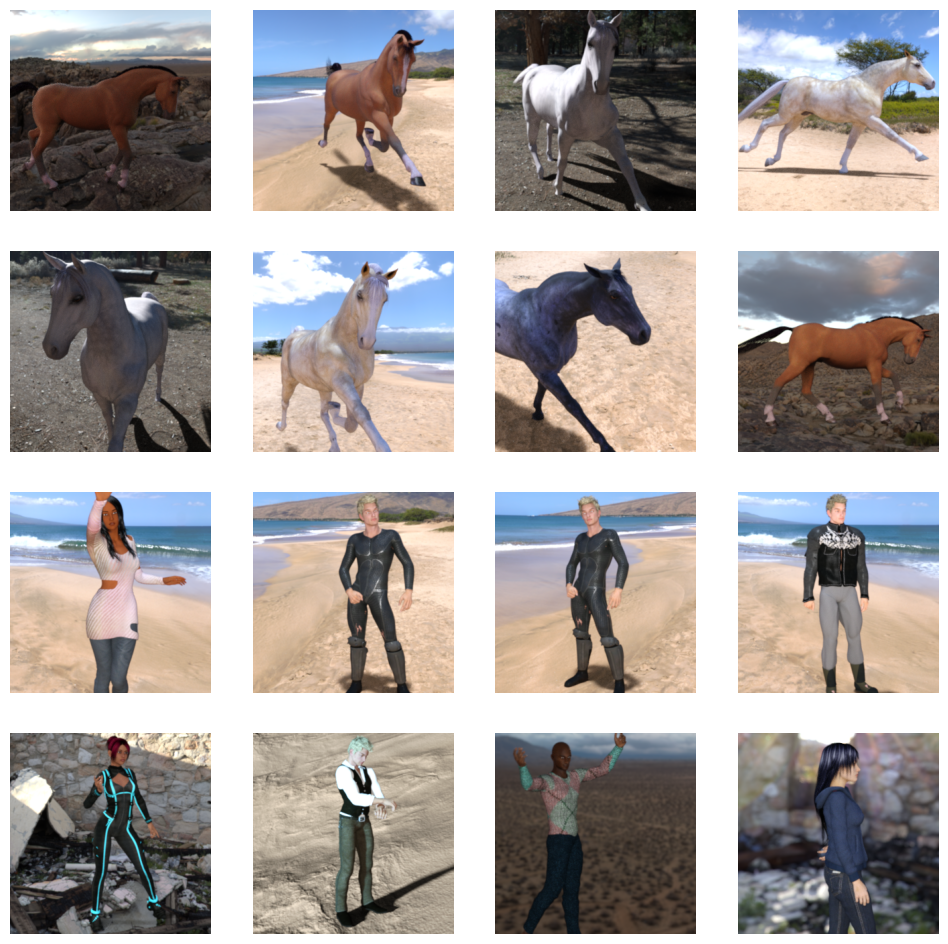

In [5]:
# Parâmetros para o gráfico (as imagens serão colocadas em uma configuração 4x4)
nrows = 4
ncols = 4

# Criando uma figura do matplotlib e setando para que o tamanho consiga caber imagens 4x4
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in random.sample(train_horse_names, k=8)]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in random.sample(train_human_names, k=8)]

for i, img_path in enumerate(next_horse_pix + next_human_pix):
    # Cria um subplot, o índice do subplot começa em 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Não mostra eixos ou linhas de grade

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

#### Pré processamento dos dados

Para preparar a base de dados de forma que ela seja recebida corretamente pelo modelo vamos usar `image_from_dataset_directory` do `tensorflow.keras`. Essa função lê as imagens das pastas de fonte, as converte em tensores e as combina com seus labels para formar uma estrutura do tipo `tf.data.Dataset`. A API `tf.data` é otimizada para processamento paralelo, usado por exemplo para alimentar GPUs e TPUs com dados. Isso torna o treinamento bem mais rápido que o uso de `numpy.array`.

Para usar o `image_from_dataset_directory`, é necessário apenas o diretório base, mas alguns argumentos adicionais podem ser usados para modificar o padrão. No nosso caso, vamos usar:
- `image_size`, que redimensiona automaticamente as imagens;
- `batch_size`, que determina o tamanho das batches nas quais os dados serão separados (para carregar os arquivos sem essa separação basta usar `batch_size=None`); e
- `label_mode`, que indica o tipo de label que devem ser atribuídos aos dados. Por padrão, os labels são assinalados em ordem alfabética e no nosso caso, serão atribuídos `0` às imagens na pasta `horses` e `1` às imagens na pasta `humans`, já que usamos o label do tipo binário.

In [6]:
# Instancia o dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(300, 300), # por padrão = (224,224)
    batch_size=32,         # por padrão = 32
    label_mode='binary'    # por padrão = "int"
)

# Checando o tipo do dataset
dataset_type = type(train_dataset)
print(f'train_dataset herda de tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}')

Found 1027 files belonging to 2 classes.
train_dataset herda de tf.data.Dataset: True


Examinando brevemente como os dados são estruturados.

Abaixo, pegamos uma batch de dados com o método `take()` e extraimos os dados, o que deve resultar numa tupla de 2 elementos, que correspondem ao par `(image, label)`.

Confirmando o formato dos elementos, o primeiro deve ter `(300,300,3)`, correspondendo as imagens, e o outro deve ter o formato `(1)`, para cada número dos labels. Ambos tendo um `32` adicional, devido ao tamanho da batch.

In [7]:
# Pega uma das batches da base de dados
sample_batch = list(train_dataset.take(1))[0]

# Checando o tipo da amostra acima
print(f'Tipo da amostra de batch: {type(sample_batch)}')
print(f'Número de elementos: {len(sample_batch)}')

# Extrai a imagem e o label
image_batch = sample_batch[0]
label_batch = sample_batch[1]

# Verifica o formato
print(f'Formato da batch de imagens: {image_batch.shape}')
print(f'Formato da batch de labels: {label_batch.shape}')

Tipo da amostra de batch: <class 'tuple'>
Número de elementos: 2
Formato da batch de imagens: (32, 300, 300, 3)
Formato da batch de labels: (32, 1)


Podemos ver um pouco do vetor da imagem e os valores dos pixels, para comparação após a normalização dos dados.

In [8]:
print(image_batch[0].numpy()[0][0:5])

[[230. 217. 198.]
 [231. 218. 199.]
 [233. 220. 201.]
 [234. 221. 201.]
 [235. 222. 202.]]


Para uma visualização mais simples, podemos somente verificar os valores mínimos e máximos dos pixels de uma imagem aleatória do dataset.

É esperado algo próximo à `min=0` `max=255`.

In [9]:
# Checando o range dos valores
print(f'Valor máximo: {np.max(image_batch[0].numpy())}')
print(f'Valor mínimo: {np.min(image_batch[0].numpy())}')

Valor máximo: 255.0
Valor mínimo: 2.0


Como já explicado nos exemplos anteriores, é uma boa prática normalizar os dados, para amenizar o processamento da Rede. Então, vamos realizar essa operação sobre nossos dados utilizando uma camada de pré processamento do tensorflow, chamada `Rescaling`. Passamos para a camada, a escala que queremos aplicar aos pixels.

In [10]:
rescale_layer = tf.keras.layers.Rescaling(scale=1./255)

Passando a imagem anterior pela camada que definimos temos o resultado a seguir:

In [11]:
image_scaled = rescale_layer(image_batch[0]).numpy()

print(image_scaled[0][0:5])

[[0.90196085 0.85098046 0.77647066]
 [0.9058824  0.854902   0.7803922 ]
 [0.91372555 0.86274517 0.78823537]
 [0.9176471  0.86666673 0.78823537]
 [0.9215687  0.8705883  0.79215693]]


In [12]:
print(f'Valor máximo: {np.max(image_scaled)}')
print(f'Valor mínimo: {np.min(image_scaled)}')

Valor máximo: 1.0
Valor mínimo: 0.007843137718737125


Existe mais de uma maneira de aplicar a transformação à todo o dataset, uma delas está implementada abaixo.

Passaremos a função de `Rescaling` que criamos acima e passá-la pelo método `map()` através da função `lambda`. Como o dataset vem em pares `(image, label)`, precisamos que ela retorne o mesmo par, mas com as imagens modificadas.

In [13]:
# Normaliza as imagens usando a função lambda
train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))

In [14]:
# Mesmo resultado que a linha acima, mas sem o uso da função lambda
# Define uma função para normalizar a imagem
def rescale_image(image, label):
    return rescale_layer(image), label

# Exemplo de uso:
# dataset_scaled = dataset.map(rescale_image)

Só para garantir, vamos pegar uma amostra do dataset modificado e verificar o range de valores dos pixels.

In [15]:
# Pega uma batch dos dados
sample_batch =  list(train_dataset_scaled.take(1))[0]

# Pega a imagem
image_scaled = sample_batch[0][1].numpy()

# Verifica o range de valores para a imagem
print(f'Valor máximo: {np.max(image_scaled)}')
print(f'Valor mínimo: {np.min(image_scaled)}')

Valor máximo: 1.0
Valor mínimo: 0.003921568859368563


Por fim, vamos utilizar mais alguns métodos para configurar nosso dataset:

* `cache()`: guarda elementos na memória enquanto os usamos, tornando mais rápido o acesso caso eles sejam necessários novamente;
* `shuffle()`: embaralha o dataset de forma aleatória; e
* `prefetch()`: pega elementos enquanto o modelo está treinando, tornando mais rápido a entrada do próximo dado quando a etapa atual de treinamento terminar. O `buffer_size` setado para `tf.data.AUTOTUNE` seta dinamicamente o número de elementos para serem carregados durante a execução.

O `cache()` e o `prefetch()` são bem úteis em aumentar a velocidade de treinamento. Depois é interessante experimentar removê-los (você verá que cada época deverá levar de 3 a 4 vezes o tempo).

In [16]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

# Configura o dataset de treinamento
train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

##### Para o dataset de validação

Caso queiramos ter um dataset de validação, podemos seguir os mesmos passos, apenas sem o `shuffle()`, já que não é necessário na validação.

In [17]:
# # Colab:
# # Pasta onde as imagens para validação estão, deve ser o caminho para a pasta "validation-horse-or-human"
# VAL_DIR = course_dir+'/data/validation-horse-or-human'

# Jupyter
# Pasta onde as imagens para validação estão, deve ser o caminho para a pasta "validation-horse-or-human"
VAL_DIR = course_dir+'\\data\\validation-horse-or-human'

# Instancia o dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(300, 300),
    batch_size=32,
    label_mode='binary'
)

# Normaliza as imagens usando a função lambda
validation_dataset_scaled = validation_dataset.map(lambda image, label: (rescale_layer(image), label))

# Configura o dataset de validação
validation_dataset_final = (validation_dataset_scaled
                           .cache()
                           .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Found 256 files belonging to 2 classes.


#### Definindo o modelo

A rede que usamos é bem similar a Rede Neural Convolucional do exemplo anterior, com algumas pequenas diferenças, principalmente devido à diferença dos dados.

* O maior número de camadas de convolução se dá pela maior complexidade e tamanho das imagens usadas;
* O formato da entrada, que neste caso são nossas imagens redimensionadas para 300x300 pixels e em RGB, ou seja, com 3 canais de cores, ao contrário da Fashion MNIST, que usava imagens em escala de cinza;
* Por fim, a camada densa de saída. Anteriormente estavamos usando 1 neurônio por classe, mas aqui temos apenas 1 neurônio para 2 classes. Isso é devido ao uso da função de ativação `sigmoid`, usada muito em classificadores binários, onde uma classe tenderá a `0` e outra classe tenderá à `1`. (OBS.: Anteriormente usamos a função de ativação `softmax`)

Comparado à uma camada de saída de 2 neurônios com uma função de ativação `softmax`, para a classificação binária, 1 neurônio com a função de ativação `sigmoid` é um pouco mais eficiente.

In [18]:
model = tf.keras.models.Sequential([
    # Note que o formato da entrada é o formato da imagem no dataset, de 300x300 com 3 bytes de cor
    tf.keras.Input(shape=(300, 300, 3)),
    # Primeira convolução
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Segunda convolução
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Terceira convolução
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Quarta convolução
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Quinta convolução
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Passa os resultados para um vetor unidimensional, para dar de entrada à rede densa
    tf.keras.layers.Flatten(),
    # 512 neurônios na camada oculta
    tf.keras.layers.Dense(512, activation='relu'),
    # Somente 1 neurônio de saída. Nele estará o valor 0 ou 1, sendo 0 para 'cavalos' e 1 para 'humanos'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Podemos observar a arquitetura da rede e o formato das saídas de cada camada com o `model.summary()`.

Lembrando que se tivéssemos dado como entrada as imagens de 300x300 pixels sem as convoluções, a camada de `Flatten()` receberia dados de tamanho `90.000` = `300*300*3`

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

A seguir, vamos compilar o modelo. Como sempre definimos a função de perda, o otimizador e as métricas a serem monitoradas durante o treinamento.

Como nosso classificador agora é binário, temos outra função de perda e outro otimizador mais adequados.

* Para a função de perda usaremos a `binary_crossentropy` devido a classificação binária e ao uso da `sigmoid` como última função de ativação (antes utilizávamos a `sparse_categorical_crossentropy`). Mais sobre [funções de perda](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).
* Já para o otimizador, utilizaremos o `RMSprop` com `learning_rate=0.001`. Usaremos o `RMSprop` em favor ao `stochastic gradient descent (SGD)`, pois o `RMSprop` automatiza o ajuste do `learning rate`. (Outros otimizadores como `Adam` e `Adagrad` também realizam esse ajuste automaticamente e também poderiam ser aplicados aqui, como o `Adam` foi no exemplo anterior).

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

#### Treinamento

Agora para o treinamento, como estamos usando o dataset no formato `tf.data.Dataset`, esta fase também é um pouco diferente. Não precisamos especificar os labels separadamente, pois ambas informações estão na estrutura `train_dataset_final`.

Como nosso problema tem uma maior complexidade, vamos aumentar o número de épocas para 15.

E o argumento `verbose` indica o quanto de informação será exibida durante o treinamento, com `verbose=2` não serão exibidas todas as mensagens sobre o progresso das épocas (nesse caso veremos que a barra de progresso será ocultada).

In [21]:
history = model.fit(
    train_dataset_final,
    epochs=15,
    verbose=2
)

Epoch 1/15
33/33 - 39s - loss: 0.6982 - accuracy: 0.5813 - 39s/epoch - 1s/step
Epoch 2/15
33/33 - 35s - loss: 0.3866 - accuracy: 0.8783 - 35s/epoch - 1s/step
Epoch 3/15
33/33 - 44s - loss: 0.1706 - accuracy: 0.9377 - 44s/epoch - 1s/step
Epoch 4/15
33/33 - 47s - loss: 0.1033 - accuracy: 0.9630 - 47s/epoch - 1s/step
Epoch 5/15
33/33 - 42s - loss: 0.1461 - accuracy: 0.9572 - 42s/epoch - 1s/step
Epoch 6/15
33/33 - 40s - loss: 0.0431 - accuracy: 0.9844 - 40s/epoch - 1s/step
Epoch 7/15
33/33 - 41s - loss: 0.2126 - accuracy: 0.9688 - 41s/epoch - 1s/step
Epoch 8/15
33/33 - 40s - loss: 0.0129 - accuracy: 0.9990 - 40s/epoch - 1s/step
Epoch 9/15
33/33 - 39s - loss: 0.0016 - accuracy: 1.0000 - 39s/epoch - 1s/step
Epoch 10/15
33/33 - 40s - loss: 0.2445 - accuracy: 0.9708 - 40s/epoch - 1s/step
Epoch 11/15
33/33 - 39s - loss: 0.0023 - accuracy: 1.0000 - 39s/epoch - 1s/step
Epoch 12/15
33/33 - 40s - loss: 0.1074 - accuracy: 0.9854 - 40s/epoch - 1s/step
Epoch 13/15
33/33 - 43s - loss: 0.0069 - accuracy

Plotando a evolução da acurácia em cada época de treinamento:

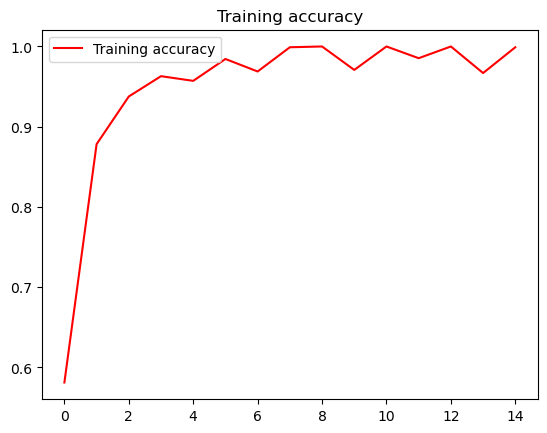

In [22]:
acc = history.history['accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.show()

#### Testando o modelo com imagens da internet.

Nesse caso podemos testar também com as imagens de validação, já que não foram usadas nesse modelo, mas é interessante testar com imagens de pessoas e cavalos reais.

As imagens que usei estão disponíveis no repositório do código.

##### Para o Google Colab

Abre uma pequena interface para upload das imagens para predição.

**OBS.:** As imagens serão puxadas do computador e não do drive.

In [29]:
from google.colab import files

# Lista na qual as imagens serão armazenadas
uploaded = files.upload()

# Itera sobre as imagens para realizar a predição
for filename in uploaded.keys():
    # Imagens para predição:
    path = '/content/'+filename
    # Carrega a imagem
    image = tf.keras.utils.load_img(path, target_size=(300,300))
    image = tf.keras.utils.img_to_array(image)
    # Usa a função definida anteriormente para normalizar a imagem
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    # Realiza a predição
    prediction = model.predict(image, verbose=0)[0][0]
    print(f"\nSaída do modelo: {prediction}")

    # Para nosso classificador binário, a saída é próxima a 0 para uma classe e próximo a 1 para a outra
    if prediction > 0.5:
        print(filename + " é um humano.")
    else:
        print(filename + " é um cavalo.")

Saving animal-4402382_1280.jpg to animal-4402382_1280.jpg
Saving horse-1139142_1280.jpg to horse-1139142_1280.jpg
Saving horse-8472924_1280.jpg to horse-8472924_1280.jpg
Saving human-3782189_1280.jpg to human-3782189_1280.jpg
Saving man-8493244_1280.jpg to man-8493244_1280.jpg
Saving white-horse-1136093_1280.jpg to white-horse-1136093_1280.jpg
Saving white-horse-3010129_1280.jpg to white-horse-3010129_1280.jpg
Saving woman-1869158_1280.jpg to woman-1869158_1280.jpg
Saving woman-5948094_1280.jpg to woman-5948094_1280.jpg

Saída do modelo: 0.00178157992195338
animal-4402382_1280.jpg é um cavalo.

Saída do modelo: 1.0
horse-1139142_1280.jpg é um humano.

Saída do modelo: 0.9992949962615967
horse-8472924_1280.jpg é um humano.

Saída do modelo: 0.9999998807907104
human-3782189_1280.jpg é um humano.

Saída do modelo: 1.0
man-8493244_1280.jpg é um humano.

Saída do modelo: 0.9999997615814209
white-horse-1136093_1280.jpg é um humano.

Saída do modelo: 0.48324570059776306
white-horse-3010129_12

##### Para o Jupyter

Abre uma pequena interface para upload das imagens para predição.

In [ ]:
from io import BytesIO

# Widgets interativos para o jupyter:
from ipywidgets import widgets

# Cria um widget para dar upload nas imagens
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ Faz a predição da imagem e printa a saída."""
    image = tf.keras.utils.load_img(file, target_size=(300, 300))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0][0]

    with out:
        if prediction > 0.5:
            print(filename + " é um humano.")
        else:
            print(filename + " é um cavalo.")


def on_upload_change(change):
    """ Pega os arquivos do widget e faz a predição."""
    # Pega o(s) arquivo(s) do upload
    items = change.new

    for item in items: # Loop para o caso de mais de um arquivo
        file_jpgdata = BytesIO(items[item]['content'])
        file_predict(items[item]['metadata']['name'], file_jpgdata, out)

# Roda o widget interativo
# Nota: após a seleção das imagens, a predição pode demorar um pouco para ser printada.
uploader.observe(on_upload_change, names='value')

#### Uma observação sobre o modelo:

Se você usou todas as imagens do repositório, pôde ver que alguns cavalos são classificados como humanos (dependendo da execução, mais ou menos imagens podem apresentar erro de classificação). Ao analisar as imagens que foram classificadas assim, poderá ver que o modelo erra para imagens em que os cavalos estão de frente ou nas quais somente a cabeça e pescoço estão aparentes.

Algumas das imagens para as quais o modelo pode apresentar erro:

<img src="https://cdn.pixabay.com/photo/2016/01/14/00/26/horse-1139142_1280.jpg" width="500"></img>

<img src="https://cdn.pixabay.com/photo/2023/12/27/22/23/horse-8472924_1280.jpg" width="500"></img>

<img src="https://cdn.pixabay.com/photo/2016/01/12/16/51/white-horse-1136093_1280.jpg" width="500"></img>

Até mesmo com algumas imagens do dataset de validação, nas quais os cavalos estão numa posição mais de frente para a câmera, é apresentado este erro na classificação.

Esse erro pode ser por vários motivos, entre eles:

- Número pequeno de imagens dos cavalos nessas posições que apresentam problemas;
- Quantidade pequena de imagens no dataset em relação a complexidade da classificação.
- Treinamento insuficiente (nesse caso talvez seja mais uma questão de utilizar os callbacks para parar o treinamento em uma época de resultados melhores).

Além disso, a imagem do anjo (abaixo) também foi erroneamente classificada como cavalo. Ao analisarmos o conjunto de dados de treinamento é possível correlacionar este erro com o fato de não termos imagens parecidas nos exemplos de humanos, e que nas imagens de cavalos, há uma grande quantidade de imagens de cavalos brancos correndo na grama. Assim, a cor branca e a grama podem estar sendo relacionadas pelo modelo à classe de cavalos.

<img src="https://cdn.pixabay.com/photo/2015/05/02/08/02/angel-749625_1280.jpg" width="500"></img>

#### Visualizando as representações intermediárias das camadas de convolução

Plotando como as features são transformadas ao longo de cada camada para uma imagem aleatória.

C:\Users\lara2\AppData\Local\Temp\ipykernel_6128\3275764296.py:39: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


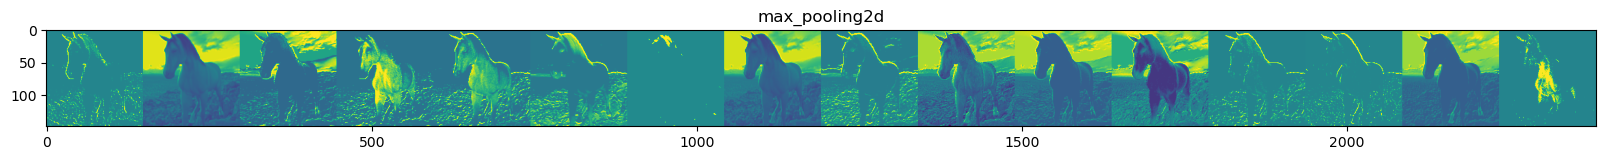

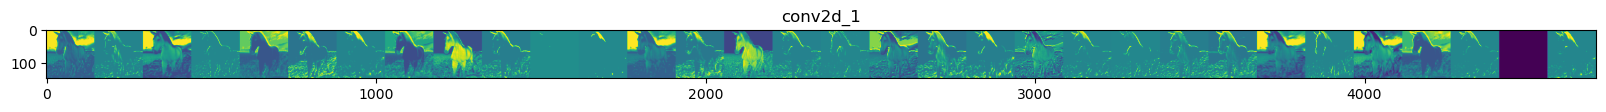

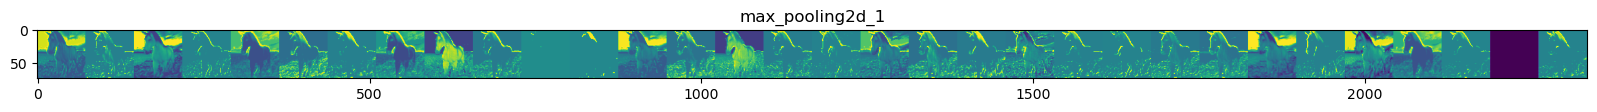

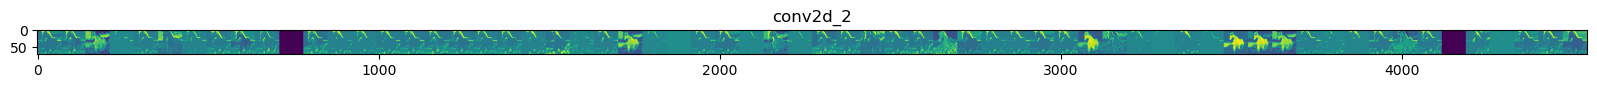

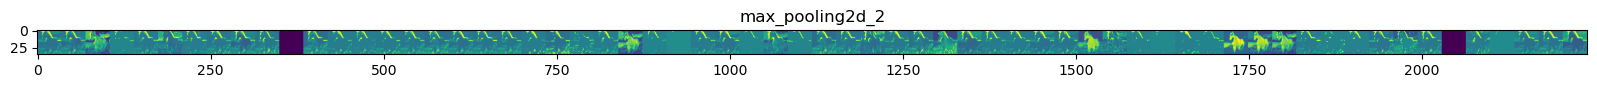

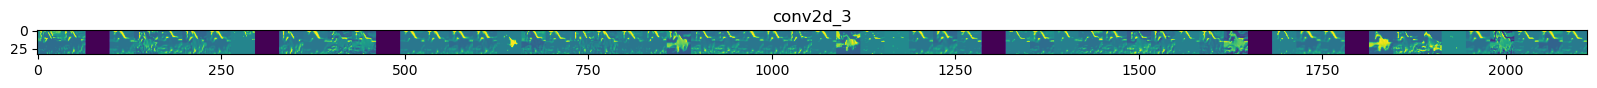

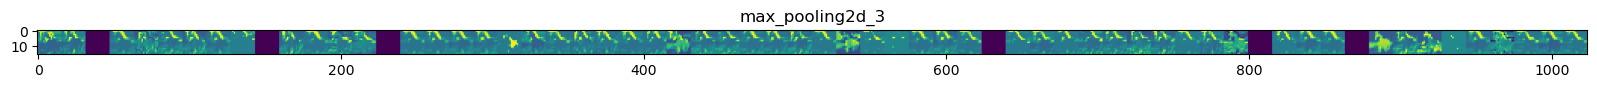

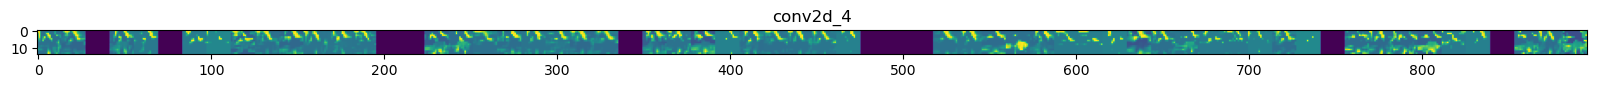

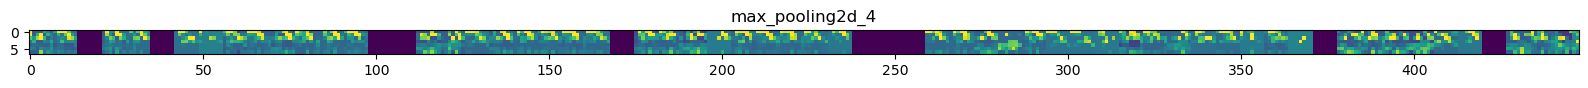

In [24]:
# Definindo um novo modelo que recebe uma imagem e tem como saída as
# representações intermediárias de cada camada no modelo anterior (com excessão da 1a)
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Preparando uma imagem aleatória do conjunto de treinamento
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = tf.keras.utils.load_img(img_path, target_size=(300, 300)) # Imagem do tipo PIL
x = tf.keras.utils.img_to_array(img)  # Vetor numpy de formato (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Vetor numpy de formato (1, 300, 300, 3)

# Reescala por 1/255
x = rescale_layer(x)

# Passa a imagem pela rede, obtendo todas as representações intermediárias para esta imagem
successive_feature_maps = visualization_model.predict(x, verbose=False)

# Obtendo os nomes das camadas para usar como título dos plots
layer_names = [layer.name for layer in model.layers[1:]]

# Plota as representações
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

        # Pega somente as camadas de convolução e maxpool, e não as totalmente conectadas
        n_features = feature_map.shape[-1]  # number of features in feature map

        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')